## Performance Log

- original (3 character context + 200 hidden neurons, 12K params): train 2.059, val 2.108
- context: 3 -> 8 (22K params): train 1.918, val 2.030
- shallow mlp -> deep WaveNet (22K params): train 1.936, val 2.025
- fixed WaveNet (22K params): train 1.908, val 2.021
- Scaled WaveNet (77K params): train 1.764, val 1.986

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
with open("names.txt", "r") as fp:
    words = fp.read().splitlines()

In [3]:
alphabet = sorted(list(set("".join(w for w in words))))
stoi = {ch: i + 1 for i, ch in enumerate(alphabet)}
stoi["."] = 0
itos = {i: ch for ch, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


## Data

In [4]:
block_size = 8

In [5]:
import typing as tp


def build_dataset(words: tp.List, block_size: int):
    X, Y = [], []
    for w in words:
        window = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(window)
            Y.append(ix)
            window = window[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


import random

random.seed(42)
random.shuffle(words)

train_size = int(0.8 * len(words))
validation_size = int(0.9 * len(words))
Xtr, Ytr = build_dataset(words[:train_size], block_size)
Xval, Yval = build_dataset(words[train_size:validation_size], block_size)
Xtest, Ytest = build_dataset(words[validation_size:], block_size)

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [45]:
import typing as tp


class Linear:
    def __init__(self, fan_in: int, fan_out: int, bias: bool = True) -> None:
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5  # kaiming_init
        self.bias = torch.randn(fan_out) if bias else None

    def __call__(self, x) -> tp.Any:
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self) -> tp.List:
        return [self.weight] + ([] if self.bias is None else [self.bias])


# ------------------------------------------------------------------------
class BatchNorm1d:
    def __init__(self, dim: int, eps=1e-5, momentum=0.1) -> None:
        self.eps = eps
        self.momentum = momentum
        self.training: bool = True

        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # buffers
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x) -> tp.Any:
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

        return self.out

    def parameters(self) -> tp.List:
        return [self.gamma, self.beta]


# ------------------------------------------------------------------------
class Tanh:
    def __call__(self, x) -> tp.Any:
        self.out = torch.tanh(x)
        return self.out

    def parameters(self) -> tp.List:
        return []


# ------------------------------------------------------------------------
class Embedding:
    def __init__(self, num_embeddings: int, embedding_dim: int) -> None:
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, x) -> tp.Any:
        self.out = self.weight[x]
        return self.out

    def parameters(self) -> tp.List:
        return [self.weight]


# ------------------------------------------------------------------------
class Flatten:
    def __call__(self, x) -> tp.Any:
        self.out = x.view(x.shape[0], -1)
        return self.out

    def parameters(self) -> tp.List:
        return []


# ------------------------------------------------------------------------
class Sequential:
    def __init__(self, layers: tp.List) -> None:
        self.layers = layers

    def __call__(self, x) -> tp.Any:
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self) -> tp.List:
        return [p for layer in self.layers for p in layer.parameters()]

In [7]:
torch.manual_seed(42)

In [8]:
def build_mlp_model(n_embed: int, n_hidden: int):
    model = Sequential(
        [
            Embedding(vocab_size, n_embed),
            Flatten(),
            Linear(n_embed * block_size, n_hidden, bias=False),
            BatchNorm1d(dim=n_hidden),
            Tanh(),
            Linear(n_hidden, vocab_size),
        ]
    )

    with torch.no_grad():
        model.layers[-1].weight *= 0.1  # last layer makes less confident

    parameters = model.parameters()
    print(f"{sum(p.nelement() for p in parameters)} in total.")
    for p in parameters:
        p.requires_grad = True

    return model

In [9]:
mlp = build_mlp_model(n_embed=10, n_hidden=200)

22097 in total.


In [23]:
# Training Loop
def train(model, Xtr, Ytr, debug: bool = False):
    epochs = 200_000
    batch_size = 32
    lossi = []

    for epoch in range(epochs):
        ix = torch.randint(0, Xtr.shape[0], (batch_size,))
        Xb, Yb = Xtr[ix], Ytr[ix]

        logits = model(Xb)
        loss = F.cross_entropy(logits, Yb)

        for p in model.parameters():
            p.grad = None
        loss.backward()

        lr = 0.1 if epoch < 150_000 else 0.01
        for p in model.parameters():
            p.data += -lr * p.grad

        if epoch % 10000 == 0:
            print(f"{epoch}/{epochs:7d}: {loss.item():4f}")

        lossi.append(loss.log10().item())

        if debug:
            break

    return lossi

In [11]:
# ~ 2mins
lossi = train(mlp, Xtr, Ytr)

0/ 200000: 3.784726
10000/ 200000: 2.022684
20000/ 200000: 2.004549
30000/ 200000: 1.745983
40000/ 200000: 1.971695
50000/ 200000: 1.994878
60000/ 200000: 2.029795
70000/ 200000: 1.908957
80000/ 200000: 2.623553
90000/ 200000: 1.862805
100000/ 200000: 2.136049
110000/ 200000: 1.888042
120000/ 200000: 1.996689
130000/ 200000: 2.135931
140000/ 200000: 2.311641
150000/ 200000: 1.956204
160000/ 200000: 2.190275
170000/ 200000: 1.647606
180000/ 200000: 2.073239
190000/ 200000: 2.062729


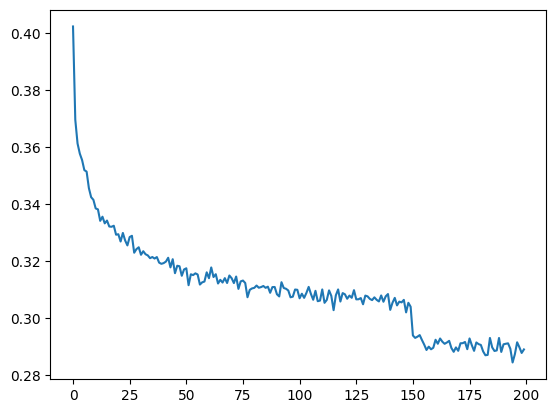

In [12]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(dim=1))

In [13]:
def set_eval_mode(model):
    for layer in model.layers:
        layer.training = False

In [14]:
set_eval_mode(mlp)

In [15]:
# Evaluation


@torch.no_grad()
def split_loss(model, split: str):
    x, y = {"train": (Xtr, Ytr), "val": (Xval, Yval), "test": (Xtest, Ytest)}[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

In [16]:
split_loss(mlp, "train")
split_loss(mlp, "val")

train 1.9184144735336304
val 2.030029296875


In [17]:
# Sample

import torch


def sample(model):
    g = torch.Generator().manual_seed(2147483647 + 10)

    for _ in range(10):
        output = []
        context = [0] * block_size  # initialize with all "..."

        while True:
            logits = model(torch.tensor([context]))  # (1, block_size, embedding_size)
            probs = F.softmax(logits, dim=1)

            ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
            context = context[1:] + [ix]

            output.append(ix)

            if ix == 0:
                break

        print("".join(itos[i] for i in output))

In [18]:
sample(mlp)

carmah.
amelle.
khyim.
shreet.
khalan.
kenrick.
nayver.
ruthaeli.
nerikia.
chaiir.


# WaveNet (shallow mlp -> deep net)

In [20]:
ix = torch.randint(0, Xtr.shape[0], (7,))
Xb = Xtr[ix]
print(Xb)

tensor([[ 0,  0,  0,  0,  0,  0,  4,  1],
        [ 0,  0,  0, 19, 11, 25, 12,  5],
        [ 0,  0,  0,  0,  0,  0,  0,  1],
        [ 0,  0,  0, 20,  5, 14, 19, 12],
        [ 0,  0,  0,  0, 10, 21, 19, 20],
        [ 0,  0,  0,  0,  0,  0, 14,  9],
        [ 0,  0, 10,  1, 13,  9, 25,  1]])


In [22]:
emb = mlp.layers[0](Xb)
x = mlp.layers[1](emb)

emb.shape, x.shape

(torch.Size([7, 8, 10]), torch.Size([7, 80]))

We now want the information from the context length (8) to fuse slowly, rather than instantly (all concatenate to 1 array).

The idea of wavenet is to first fuse 2 adjacents together, making 4 of tuples of 2. Then repeatly fuse 2 adjacents together, making 2 of tuples of 4. Finally fuse the 2 tuples together and make eveything concatenated together.

Thus, we will have 3 layers instead of 1.

For example, we have embedding size as (7, 8, 10). We want the 1st flatten layer output to have (7, 4, 20), 2nd flatten layer output to be (7, 2, 40), and 3rd flatter layer output to be (7, 80) (remove the 1 dimemsion).

In [27]:
# FlattenConsecutive(block_size) equals Flatten()
class FlattenConsecutive:
    def __init__(self, n) -> None:
        self.n = n

    def __call__(self, x) -> tp.Any:
        B, T, C = x.shape  # Batch size, Context Length (or Block Size), Embbedding Size (or Channel Size)
        # Note this is different from PyTorch, which usually has (B, C, T), or (N, C, L)
        x = x.view(B, T // self.n, C * self.n)
        if x.shape[1] == 1:
            # remove T if T == 1. We want (7, 80) but not (7, 1, 80).
            x = x.squeeze(dim=1)
        self.out = x
        return self.out

    def parameters(self) -> tp.List:
        return []

In [24]:
def build_deepnet(n_embed: int, n_hidden: int):
    deep_net = Sequential(
        [
            Embedding(num_embeddings=vocab_size, embedding_dim=n_embed),
            #
            FlattenConsecutive(2),
            Linear(n_embed * 2, n_hidden),
            BatchNorm1d(n_hidden),
            Tanh(),
            #
            FlattenConsecutive(2),
            Linear(n_hidden * 2, n_hidden),
            BatchNorm1d(n_hidden),
            Tanh(),
            #
            FlattenConsecutive(2),
            Linear(n_hidden * 2, n_hidden),
            BatchNorm1d(n_hidden),
            Tanh(),
            # Final
            Linear(n_hidden, vocab_size),
        ]
    )

    with torch.no_grad():
        deep_net.layers[-1].weight *= 0.1  # make the final layer less confident

    for p in deep_net.parameters():
        p.requires_grad = True

    return deep_net

In [30]:
def get_total_params(model) -> int:
    return sum(p.nelement() for layer in model.layers for p in layer.parameters())

In [40]:
# Decrease hidden layer size to have roughly the same params as the shallow mlp.
torch.manual_seed(42)
deep_net = build_deepnet(n_embed=10, n_hidden=68)

In [38]:
print(f"Total params: {get_total_params(deep_net)}")

Total params: 22601


In [34]:
def display_net(model):
    for layer in model.layers:
        print(layer.__class__.__name__, ":", tuple(layer.out.shape))

In [39]:
# Run 1 epoch and check the dimensions
train(deep_net, Xtr, Ytr, debug=True)
display_net(deep_net)

0/ 200000: 3.426891
Embedding : (32, 8, 10)
FlattenConsecutive : (32, 4, 20)
Linear : (32, 4, 68)
BatchNorm1d : (32, 4, 68)
Tanh : (32, 4, 68)
FlattenConsecutive : (32, 2, 136)
Linear : (32, 2, 68)
BatchNorm1d : (32, 2, 68)
Tanh : (32, 2, 68)
FlattenConsecutive : (32, 136)
Linear : (32, 68)
BatchNorm1d : (32, 68)
Tanh : (32, 68)
Linear : (32, 27)


In [41]:
# ~ 4 mins
lossi = train(deep_net, Xtr, Ytr, debug=False)

0/ 200000: 3.426891
10000/ 200000: 1.978816
20000/ 200000: 2.449963
30000/ 200000: 2.067654
40000/ 200000: 1.991763
50000/ 200000: 2.211178
60000/ 200000: 2.203613
70000/ 200000: 2.108956
80000/ 200000: 1.878155
90000/ 200000: 2.312333
100000/ 200000: 1.978967
110000/ 200000: 1.425199
120000/ 200000: 2.203280
130000/ 200000: 1.651695
140000/ 200000: 2.213243
150000/ 200000: 2.155809
160000/ 200000: 2.157286
170000/ 200000: 2.228059
180000/ 200000: 2.046267
190000/ 200000: 1.925675


In [42]:
set_eval_mode(deep_net)
split_loss(deep_net, "train")
split_loss(deep_net, "val")

train 1.936240792274475
val 2.0253868103027344


# Fix BatchNorm for 3d inputs

Our 1st layer output is of size (32, 4, 68), and we want to batch norm the entire (32 * 4) examples, but not 32 examples.

In other words, we treat all but the last dimension as batches, and calculate the mean and variance of examples.

In [49]:
class BatchNorm1d:
    def __init__(self, dim: int, eps=1e-5, momentum=0.1) -> None:
        self.eps = eps
        self.momentum = momentum
        self.training: bool = True

        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # buffers
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x) -> tp.Any:
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:  # Treat the first 2 dims as batches.
                dim = (0, 1)
            xmean = x.mean(dim, keepdim=True)
            xvar = x.var(dim, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

        return self.out

    def parameters(self) -> tp.List:
        return [self.gamma, self.beta]

In [51]:
torch.manual_seed(42)
fixed_bn_deepnet = build_deepnet(n_embed=10, n_hidden=68)
train(fixed_bn_deepnet, Xtr, Ytr, debug=True)
display_net(fixed_bn_deepnet)

0/ 200000: 3.420827
Embedding : (32, 8, 10)
FlattenConsecutive : (32, 4, 20)
Linear : (32, 4, 68)
BatchNorm1d : (32, 4, 68)
Tanh : (32, 4, 68)
FlattenConsecutive : (32, 2, 136)
Linear : (32, 2, 68)
BatchNorm1d : (32, 2, 68)
Tanh : (32, 2, 68)
FlattenConsecutive : (32, 136)
Linear : (32, 68)
BatchNorm1d : (32, 68)
Tanh : (32, 68)
Linear : (32, 27)


In [52]:
# ~ 5mins
lossi = train(fixed_bn_deepnet, Xtr, Ytr, debug=False)

0/ 200000: 3.489251
10000/ 200000: 2.149081
20000/ 200000: 2.133515
30000/ 200000: 1.919038
40000/ 200000: 2.144388
50000/ 200000: 2.436729
60000/ 200000: 1.999422
70000/ 200000: 1.951678
80000/ 200000: 2.215482
90000/ 200000: 2.122622
100000/ 200000: 1.907369
110000/ 200000: 1.738320
120000/ 200000: 2.117441
130000/ 200000: 2.035177
140000/ 200000: 1.733167
150000/ 200000: 1.459346
160000/ 200000: 1.932294
170000/ 200000: 1.754429
180000/ 200000: 2.260017
190000/ 200000: 2.020680


In [53]:
set_eval_mode(fixed_bn_deepnet)
split_loss(fixed_bn_deepnet, "train")
split_loss(fixed_bn_deepnet, "val")

train 1.9079331159591675
val 2.0214245319366455


# Scale Up WaveNet

In [54]:
torch.manual_seed(42)
scale_up_deepnet = build_deepnet(n_embed=24, n_hidden=128)
train(scale_up_deepnet, Xtr, Ytr, debug=True)
print(f"Total params: {get_total_params(scale_up_deepnet)}")
display_net(scale_up_deepnet)

0/ 200000: 4.093812
Total params: 76963
Embedding : (32, 8, 24)
FlattenConsecutive : (32, 4, 48)
Linear : (32, 4, 128)
BatchNorm1d : (32, 4, 128)
Tanh : (32, 4, 128)
FlattenConsecutive : (32, 2, 256)
Linear : (32, 2, 128)
BatchNorm1d : (32, 2, 128)
Tanh : (32, 2, 128)
FlattenConsecutive : (32, 256)
Linear : (32, 128)
BatchNorm1d : (32, 128)
Tanh : (32, 128)
Linear : (32, 27)


In [55]:
# ~ 6 mins
lossi = train(scale_up_deepnet, Xtr, Ytr, debug=False)

0/ 200000: 4.299056
10000/ 200000: 1.807935
20000/ 200000: 1.839669
30000/ 200000: 2.325362
40000/ 200000: 2.633104
50000/ 200000: 1.852282
60000/ 200000: 1.825101
70000/ 200000: 1.807695
80000/ 200000: 1.864138
90000/ 200000: 1.719553
100000/ 200000: 1.927642
110000/ 200000: 1.935086
120000/ 200000: 1.983012
130000/ 200000: 2.043944
140000/ 200000: 1.637899
150000/ 200000: 1.976491
160000/ 200000: 1.631560
170000/ 200000: 2.096230
180000/ 200000: 1.821052
190000/ 200000: 1.858011


In [56]:
set_eval_mode(scale_up_deepnet)
split_loss(scale_up_deepnet, "train")
split_loss(scale_up_deepnet, "val")

train 1.764479160308838
val 1.9862309694290161
